In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from wsgiref.simple_server import make_server

# Load the earthquake dataset
earthquake_data = pd.read_csv('earthquake_1995-2023.csv')

# Convert date_time to datetime
earthquake_data['date_time'] = pd.to_datetime(earthquake_data['date_time'], format='%d-%m-%Y %H:%M')

# Select relevant features
features = ['magnitude', 'cdi', 'mmi', 'tsunami', 'sig', 'nst', 'dmin', 'gap', 'depth', 'latitude', 'longitude']

# Fill missing values
earthquake_data[features] = earthquake_data[features].fillna(earthquake_data[features].mean())

# Convert 'alert' column to numerical
earthquake_data['alert'] = earthquake_data['alert'].fillna('green')  # Fill missing alerts with 'green'
alert_mapping = {'green': 0, 'yellow': 1, 'orange': 2, 'red': 3}
earthquake_data['alert'] = earthquake_data['alert'].map(alert_mapping)

# Normalize numerical features
scaler = StandardScaler()
X = scaler.fit_transform(earthquake_data[features])
y = earthquake_data['alert']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# One-hot encode the target variable
encoder = OneHotEncoder()
y_train = encoder.fit_transform(y_train.values.reshape(-1, 1)).toarray()
y_test = encoder.transform(y_test.values.reshape(-1, 1)).toarray()

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# Reshape the data for LSTM
X_train_reshaped = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Build the LSTM model
model = Sequential()
#Input Layer
model.add(LSTM(50, return_sequences=True, input_shape=(1, X_train.shape[1])))

#Hidden Layer
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))

#Output Layer
model.add(Dense(y_train.shape[1], activation='softmax'))


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_reshaped, y_train, epochs=21, batch_size=32, validation_data=(X_test_reshaped, y_test))


Epoch 1/21
91/91 [==============================] - 8s 26ms/step - loss: 1.1976 - accuracy: 0.5868 - val_loss: 0.9049 - val_accuracy: 0.5760
Epoch 2/21
91/91 [==============================] - 1s 7ms/step - loss: 0.6918 - accuracy: 0.7452 - val_loss: 0.5371 - val_accuracy: 0.8301
Epoch 3/21
91/91 [==============================] - 1s 6ms/step - loss: 0.4138 - accuracy: 0.8700 - val_loss: 0.3628 - val_accuracy: 0.8729
Epoch 4/21
91/91 [==============================] - 1s 7ms/step - loss: 0.3133 - accuracy: 0.8797 - val_loss: 0.3039 - val_accuracy: 0.8936
Epoch 5/21
91/91 [==============================] - 1s 7ms/step - loss: 0.2683 - accuracy: 0.8959 - val_loss: 0.2719 - val_accuracy: 0.8826
Epoch 6/21
91/91 [==============================] - 1s 6ms/step - loss: 0.2408 - accuracy: 0.8938 - val_loss: 0.2498 - val_accuracy: 0.8785
Epoch 7/21
91/91 [==============================] - 1s 8ms/step - loss: 0.2182 - accuracy: 0.9015 - val_loss: 0.2294 - val_accuracy: 0.9019
Epoch 8/21
91/91 [=

In [12]:
import pickle

# Save the model
# Replace this line where you save your model as HDF5:
model.save('natural_disaster_lstm_model.h5')
# Save the scaler and encoder
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
with open('encoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)

C:\Users\RANJIT KUMAR\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


23/23 [==============================] - 2s 6ms/step - loss: 0.1266 - accuracy: 0.9586
Test Accuracy: 95.86%


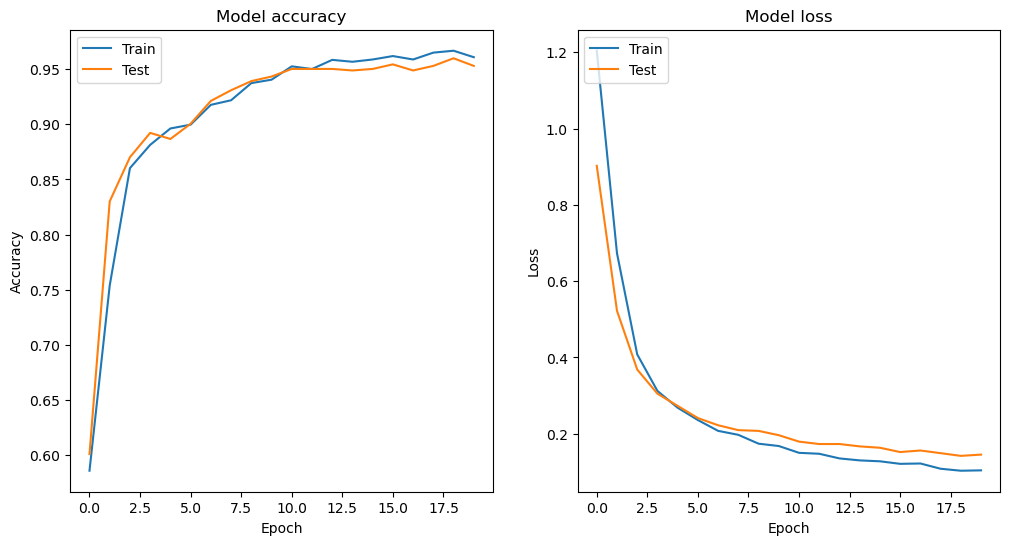

In [19]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_reshaped, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Plot training & validation accuracy and loss values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('new_accuracy_plot.png')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('new_loss_plot.png')


In [20]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = earthquake_data[earthquake_data.alert == 0]
df_minority1 = earthquake_data[earthquake_data.alert == 1]
df_minority2 = earthquake_data[earthquake_data.alert == 2]
df_minority3 = earthquake_data[earthquake_data.alert == 3]

# Upsample minority classes
df_minority1_upsampled = resample(df_minority1,
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=42) # reproducible results

df_minority2_upsampled = resample(df_minority2,
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=42) # reproducible results

df_minority3_upsampled = resample(df_minority3,
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=42) # reproducible results

# Combine majority class with upsampled minority classes
df_upsampled = pd.concat([df_majority, df_minority1_upsampled, df_minority2_upsampled, df_minority3_upsampled])

# Display new class counts
print(df_upsampled['alert'].value_counts())


0    904
1    904
2    904
3    904
Name: alert, dtype: int64


In [21]:
# Prepare the data
X = df_upsampled[features]
y = df_upsampled['alert']

# Normalize numerical features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# One-hot encode the target variable
encoder = OneHotEncoder()
y = encoder.fit_transform(y.values.reshape(-1, 1)).toarray()

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the data for LSTM
X_train_reshaped = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Build and train the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(1, X_train.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_reshaped, y_train, epochs=20, batch_size=32, validation_data=(X_test_reshaped, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test_reshaped, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Make predictions on the test set
predictions = model.predict(X_test_reshaped)

# Convert predictions back to original labels
predicted_labels = encoder.inverse_transform(predictions)

# Compare with actual labels
actual_labels = encoder.inverse_transform(y_test)

# Print some sample predictions and actual values
for i in range(10):
    print(f'Predicted: {predicted_labels[i][0]}, Actual: {actual_labels[i][0]}')

# Calculate and print accuracy
correct_predictions = sum(predicted_labels.flatten() == actual_labels.flatten())
total_predictions = len(actual_labels)
accuracy = correct_predictions / total_predictions
print(f'Calculated Accuracy: {accuracy * 100:.2f}%')

# Define different sample inputs to test various alert levels
sample_inputs = [
    {
        'description': 'Green Alert Example',
        'data': {
            'magnitude': 2.5,
            'cdi': 1.0,
            'mmi': 1.5,
            'tsunami': 0,
            'sig': 50,
            'nst': 10,
            'dmin': 0.1,
            'gap': 180,
            'depth': 5.0,
            'latitude': 34.0522,
            'longitude': -118.2437
        }
    },
    {
        'description': 'Yellow Alert Example',
        'data': {
            'magnitude': 4.5,
            'cdi': 3.0,
            'mmi': 3.5,
            'tsunami': 0,
            'sig': 150,
            'nst': 20,
            'dmin': 0.2,
            'gap': 90,
            'depth': 10.0,
            'latitude': 37.7749,
            'longitude': -122.4194
        }
    },
    {
        'description': 'Orange Alert Example',
        'data': {
            'magnitude': 6.0,
            'cdi': 5.0,
            'mmi': 5.5,
            'tsunami': 0,
            'sig': 400,
            'nst': 30,
            'dmin': 0.3,
            'gap': 60,
            'depth': 15.0,
            'latitude': 40.7128,
            'longitude': -74.0060
        }
    },
    {
        'description': 'Red Alert Example',
        'data': {
            'magnitude': 7.5,
            'cdi': 7.0,
            'mmi': 7.5,
            'tsunami': 1,
            'sig': 700,
            'nst': 40,
            'dmin': 0.5,
            'gap': 30,
            'depth': 20.0,
            'latitude': 35.6895,
            'longitude': 139.6917
        }
    }
]

# Function to predict alert level for a given input
def predict_alert(input_data):
    prepared_data = np.array([input_data[feature] for feature in features]).reshape(1, -1)
    scaled_data = scaler.transform(prepared_data)
    reshaped_data = np.reshape(scaled_data, (1, 1, scaled_data.shape[1]))
    prediction = model.predict(reshaped_data)
    predicted_alert = encoder.inverse_transform(prediction)[0][0]
    return predicted_alert

# Print predictions for each sample input
for sample in sample_inputs:
    description = sample['description']
    input_data = sample['data']
    predicted_alert = predict_alert(input_data)
    print(f'{description} Prediction: {predicted_alert}')


Epoch 1/20
91/91 [==============================] - 9s 23ms/step - loss: 1.1859 - accuracy: 0.6186 - val_loss: 0.8918 - val_accuracy: 0.6423
Epoch 2/20
91/91 [==============================] - 1s 7ms/step - loss: 0.6795 - accuracy: 0.7628 - val_loss: 0.5370 - val_accuracy: 0.8191
Epoch 3/20
91/91 [==============================] - 1s 8ms/step - loss: 0.4162 - accuracy: 0.8683 - val_loss: 0.3635 - val_accuracy: 0.8757
Epoch 4/20
91/91 [==============================] - 1s 7ms/step - loss: 0.3145 - accuracy: 0.8811 - val_loss: 0.3089 - val_accuracy: 0.8812
Epoch 5/20
91/91 [==============================] - 1s 6ms/step - loss: 0.2716 - accuracy: 0.8876 - val_loss: 0.2802 - val_accuracy: 0.8757
Epoch 6/20
91/91 [==============================] - 1s 6ms/step - loss: 0.2413 - accuracy: 0.8914 - val_loss: 0.2510 - val_accuracy: 0.8840
Epoch 7/20
91/91 [==============================] - 1s 10ms/step - loss: 0.2241 - accuracy: 0.8970 - val_loss: 0.2326 - val_accuracy: 0.8840
Epoch 8/20
91/91 [

C:\Users\RANJIT KUMAR\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\RANJIT KUMAR\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 39ms/step
Yellow Alert Example Prediction: 1
1/1 [==============================] - 0s 24ms/step
Orange Alert Example Prediction: 1


C:\Users\RANJIT KUMAR\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\RANJIT KUMAR\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 38ms/step
Red Alert Example Prediction: 1


In [22]:
!pip install flask-cors

In [23]:
!pip install gunicorn

In [24]:
from flask import Flask, request, jsonify
from flask_cors import CORS
from tensorflow.keras.models import load_model
import numpy as np
import pickle
from wsgiref.simple_server import make_server
import tensorflow as tb
from tensorflow import keras

# Initialize Flask app
app = Flask(__name__)
CORS(app)  # Enable CORS

# Load the model and preprocessing objects
model = load_model('natural_disaster_lstm_model.h5')
with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)
with open('encoder.pkl', 'rb') as f:
    encoder = pickle.load(f)

@app.route('/predict', methods=['POST'])
def predict():
    data = request.json
    input_data = np.array([data['magnitude'], data['cdi'], data['mmi'], data['tsunami'], data['sig'], data['nst'], data['dmin'], data['gap'], data['depth'], data['latitude'], data['longitude']])
    input_data_scaled = scaler.transform([input_data])
    input_data_reshaped = np.reshape(input_data_scaled, (1, 1, input_data_scaled.shape[1]))
    prediction = model.predict(input_data_reshaped)
    result = encoder.inverse_transform(prediction)[0][0]
    return jsonify({'prediction': result})

if __name__ == '__main__':
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with watchdog (windowsapi)


SystemExit: 1

C:\Users\RANJIT KUMAR\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3513: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
from flask import Flask, request, jsonify
from tensorflow.keras.models import load_model
import numpy as np
import pickle
from wsgiref.simple_server import make_server
import tensorflow as tf
from tensorflow import keras

# Initialize Flask app
app = Flask(__name__)

# Load the model and preprocessing objects
model = load_model('natural_disaster_lstm_model.h5')
with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)
with open('encoder.pkl', 'rb') as f:
    encoder = pickle.load(f)

@app.route('/predict', methods=['POST'])
def predict():
    data = request.json
    input_data = np.array([data['magnitude'], data['cdi'], data['mmi'], data['tsunami'], data['sig'], data['nst'], data['dmin'], data['gap'], data['depth'], data['latitude'], data['longitude']])
    input_data_scaled = scaler.transform([input_data])
    input_data_reshaped = np.reshape(input_data_scaled, (1, 1, input_data_scaled.shape[1]))
    prediction = model.predict(input_data_reshaped)
    result = encoder.inverse_transform(prediction)[0][0]
    return jsonify({'prediction': result})

if __name__ == '__main__':
    app.run()


In [ ]:
!pip python app.py

In [ ]:
df_majority = earthquake_data[earthquake_data.alert == 0]
df_minority1 = earthquake_data[earthquake_data.alert == 1]
df_minority2 = earthquake_data[earthquake_data.alert == 2]
df_minority3 = earthquake_data[earthquake_data.alert == 3]